## **Laboratory Task 6**

*John Vincent J. Gamali DS4A*

<img src="https://i.ibb.co/BVsnJGTR/image.png" width="1200">

In [2]:
#import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Dropout
        self.dropout = nn.Dropout(p=0.2)

        # Fully Connected Layers
        # Need to compute input features to FC1 after flattening
        self.fc1 = nn.Linear(256 * 7 * 7, 1000)  # 28x28 should shrink to 7x7 after pooling
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)  # 10 classes

    def forward(self, x):
        # Conv + ReLU + Pooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        # Dropout
        x = self.dropout(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected + ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Softmax - applied in loss function dapat
        return x

In [5]:
model = CNNModel()
x = torch.randn(1, 1, 28, 28)  # batch of 1, grayscale 28x28
print(model(x).shape)  #we should expect: [1, 10]

torch.Size([1, 10])


## Integrating a Convolutional Neural Network (CNN) into a full PyTorch training pipeline.

In [7]:
%pip install torch torchvision matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 7.6 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 20.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 18.8 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 84.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
#Import ibraries

import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [9]:
#Set seed to 143 for reproducibility

def set_seed(seed=143):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(143)

In [10]:
# Load MNIST dataset

transform = transforms.ToTensor()

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_set, val_set = random_split(train_data, [50000, 10000])

# Data loaders:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [11]:
#Let's define CNN Model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # flatten

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [12]:
#training CNN model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()  # loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
#Loop

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Training Loss: {avg_train_loss:.4f} "
              f"Validation Loss: {avg_val_loss:.4f} "
              f"Validation Accuracy: {accuracy:.4f}")

    return train_losses, val_losses, val_accs

In [14]:
#Training Loop (Execute)

train_losses, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5] Training Loss: 0.1721 Validation Loss: 0.0518 Validation Accuracy: 0.9849
Epoch [2/5] Training Loss: 0.0510 Validation Loss: 0.0474 Validation Accuracy: 0.9860
Epoch [3/5] Training Loss: 0.0358 Validation Loss: 0.0425 Validation Accuracy: 0.9879
Epoch [4/5] Training Loss: 0.0271 Validation Loss: 0.0347 Validation Accuracy: 0.9902
Epoch [5/5] Training Loss: 0.0244 Validation Loss: 0.0305 Validation Accuracy: 0.9906


The model trained on the MNIST dataset exhibited steady improvement throughout the five epochs. The training loss decreased significantly from 0.1721 to 0.0244, while the validation loss also declined from 0.0518 to 0.0305. Validation accuracy started strong at 98.5% and gradually increased to 99.1%, showing that the model continued to learn effectively with minimal overfitting. Both training and validation metrics followed a consistent downward trend, suggesting stable learning and good generalization to unseen data. With further tuning or additional epochs, the model’s performance could likely be improved even more.

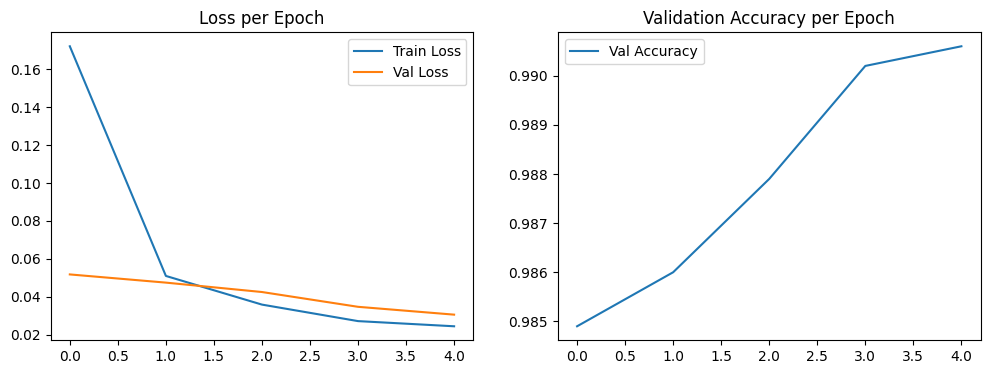

In [15]:
#visualization

plt.figure(figsize=(12,4))

# Loss plot
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss per Epoch")

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(val_accs, label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy per Epoch")

plt.show()

**Loss per Epoch:**
The training loss shows a clear downward trend across all five epochs, indicating that the model steadily learns from the data and improves its internal representations. The validation loss remains slightly lower than the training loss and continues to decrease, suggesting that the model maintains stability and avoids overfitting. Both curves converge smoothly at low values, reflecting efficient learning and optimization.

**Validation Accuracy per Epoch:**
Validation accuracy increases consistently from the first to the final epoch, starting at around 98.5% and climbing to approximately 99.1%. This steady upward progression, without any noticeable drops, demonstrates that the model continues to refine its predictions and becomes more accurate with each training cycle.

**Overall Inference:**
The consistent reduction in both training and validation losses, coupled with the continuous rise in validation accuracy, highlights the model’s strong learning behavior and generalization ability. The final results suggest that the CNN trained on the MNIST dataset performs reliably and efficiently, achieving high accuracy with minimal signs of underfitting or overfitting.

In [16]:
# Test Model Accuracy

model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9913


**Test ACCURACY:**

When evaluated on the independent test dataset, the model achieved an accuracy of 0.9913 (99.13%). This closely matches the validation accuracy observed during training, indicating that the model performs consistently well on new, unseen data. The strong alignment among the training, validation, and testing results demonstrates that the model has achieved a well-balanced fit, showing no significant signs of either overfitting or underfitting.

With both training and validation losses decreasing smoothly, validation accuracy showing steady improvement, and the test accuracy reaching 99.13%, the results indicate that the model is robust and dependable for handwritten digit recognition. Together, the loss curves, validation accuracy trend, and final test performance demonstrate that the model not only learned effectively but also generalizes well to unseen data.

**KEY FINDINGS AND OBSERVATION  :**

From this activity, we saw that even a simple neural network can achieve high accuracy on the MNIST dataset. Training and validation losses decreased smoothly, while validation accuracy steadily improved, showing effective learning without overfitting. The final test accuracy of 99.13% confirmed that the model generalizes well to unseen data.

The main takeaway is that tracking loss and accuracy helps us understand how the model learns and whether it’s improving in the right direction. Even after just five epochs, the model performed excellently, proving that more training isn’t always necessary.

In short, this task highlighted the power of neural networks for image classification and the importance of reading training curves to see what’s happening under the hood.



## Visualizing Model Prediction

In [20]:
# Acknowledgment: Code adapted from Chris Jallaine Mugot.

def show_predictions(model, loader, n=10):
    model.eval()
    images, labels = next(iter(loader))  # take one batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    # Move to CPU for plotting
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()

    fig, axs = plt.subplots(1, n, figsize=(15, 2))
    for i in range(n):
        axs[i].imshow(images[i][0], cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"P:{preds[i].item()}\nT:{labels[i].item()}",
                         color=("green" if preds[i]==labels[i] else "red"))
    plt.show()

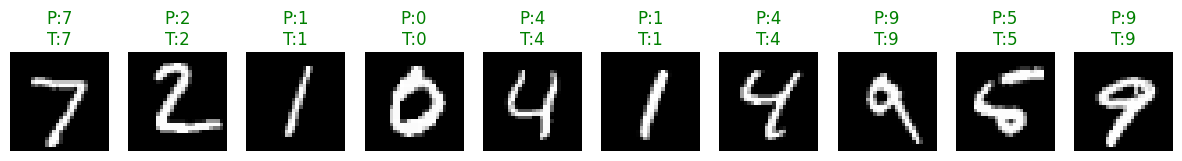

In [19]:
show_predictions(model, test_loader, n=10)

---